# `pynucastro`: Reaction Network Integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Integration Methods

#### First-Order Implicit Euler

$\newcommand{\bv}[1]{\mathbf{#1}}$
$\newcommand{\ptl}{\partial}$

When integrating the abundances forward, $\bv{y}_{n+1}=\bv{y}_n+\bv{\Delta}$, where $\bv{\Delta}$ is found by expanding $\bv{y}_{n+1} = \bv{y}_n+h\cdot \bv{f}(\bv{y}_{n+1})$ to first order around $\bv{f(\bv{y}_n)}$: $$\begin{align*}
	\bv{y}_{n+1} = \bv{y}_n+\bv{\Delta} &= \bv{y}_n+h\cdot\bv{f}(\bv{y}_{n+1})\\
	&= \bv{y}_n+h\cdot\left[\bv{f}(\bv{y}_n)+\frac{\ptl \bv{f}}{\ptl \bv{y}}\bigg\rvert_{\bv{y}_n}\cdot \bv{\Delta}\right]\\
	&\implies \\
	\left[\frac{\bv{I}}{h}-\bv{J}\right]\cdot \bv{\Delta} &= \bv{f}(\bv{y}_n)
	\end{align*}$$
	
Thus, this algorithm requires four computations per step: evaluate $\bv{J}$, evaluate $\bv{f}(\bv{y}_n)$, solve the matrix equation for $\bv{\Delta}$, then plug in to complete the step forward. However, this method doesn't contain any self-reference to a higher order to estimate if the step was accurate or not.

#### Fourth-order Kaps-Rentrop

$\newcommand{\bv}[1]{\mathbf{#1}}$
$\newcommand{\ptl}{\partial}$

Similar to the Runge-Kutta methods, incremental steps can be made and combined in a certain linear combination to yield higher order accuracy: $\bv{y}_{n+1}=\bv{y}_n+\sum_{i=1}^4 b_i \bv{\Delta}_i,$ where the $\bv{\Delta}_i$ vectors are found from solving the following equations successively: $$\begin{align*}
	\left[\frac{\bv{I}}{\gamma h}-\bv{J}\right]\cdot \bv{\Delta}_1 &= \bv{f}(\bv{y}_n) \\	\left[\frac{\bv{I}}{\gamma h}-\bv{J}\right]\cdot \bv{\Delta}_2 &= \bv{f}(\bv{y}_n+a_{21}\bv{\Delta}_1)+c_{21} \bv{\Delta}_1/h \\	\left[\frac{\bv{I}}{\gamma h}-\bv{J}\right]\cdot \bv{\Delta}_3 &= \bv{f}(\bv{y}_n+a_{31}\bv{\Delta}_1+a_{32}\bv{\Delta}_2)+(c_{31}\bv{\Delta}_1+c_{32}\bv{\Delta}_2)/h \\	\left[\frac{\bv{I}}{\gamma h}-\bv{J}\right]\cdot \bv{\Delta}_4 &= \bv{f}(\bv{y}_n+a_{31}\bv{\Delta}_1+a_{32}\bv{\Delta}_2)+(c_{41}\bv{\Delta}_1+c_{42}\bv{\Delta}_2+c_{43}\bv{\Delta}_3)/h
	\end{align*}$$
	
The coefficients $\gamma$, $a_{ij}$, $b_i$, and $c_{ij}$ have fixed values. This method has coefficients giving an error estimate as well: $\bv{E}=\sum_{i=1}^4 e_i\cdot\bv{\Delta}_i$. ([Numerical Recipes In Fortran
](https://isbnsearch.org/isbn/9780521430647).)

#### Variable-order Bader-Deuflhard

$\newcommand{\bv}[1]{\mathbf{#1}}$
$\newcommand{\ptl}{\partial}$

The final method advances over a larger timestep $H$ in $m$ successive steps ($h=H/m)$, first through 

$$\begin{align*}
	\left[\bv{I}-h\bv{J}\right]\cdot \bv{\Delta}_0 = h \bv{f}(\bv{y}_n),\ \ \bv{y}_1=\bv{y}_n+\bv{\Delta}_0.
	\end{align*}$$
    
Then, from $k=1$ to $m-1$, $$\begin{align*}
	\left[\bv{I}-h\bv{J}\right]\cdot \bv{x} &= h \bv{f}(\bv{y}_i)-\bv{\Delta}_{k-1}\\
	\bv{\Delta}_k &= \bv{\Delta}_{k-1}+2\bv{x}\\
	\bv{y}_{k+1} &= \bv{y}_k+\bv{\Delta}_k
	\end{align*}$$

and then a final update of $$\left[\bv{I}-h\bv{J}\right]\cdot\bv{\Delta}_m = h\bv{f}(\bv{y}_m)-\bv{\Delta}_{m-1},\ \ \bv{y}_{m+1}=\bv{y}_m+\bv{\Delta}_m.$$
	
The inner sequence is done at least twice with $m=2$ and $m=6$ to estimate error. The base cost per step of this method is one evaluation of $\bv{J}$, eight evaluations of $\bv{f}$ (for $m=2$ and $m=6$) and $\bv{x}$, and solving for $\Delta$ twice. If higher-order accuracy is needed, $m$ increases and the cost grows with it.

# Integration Case Study: The CNO Cycle

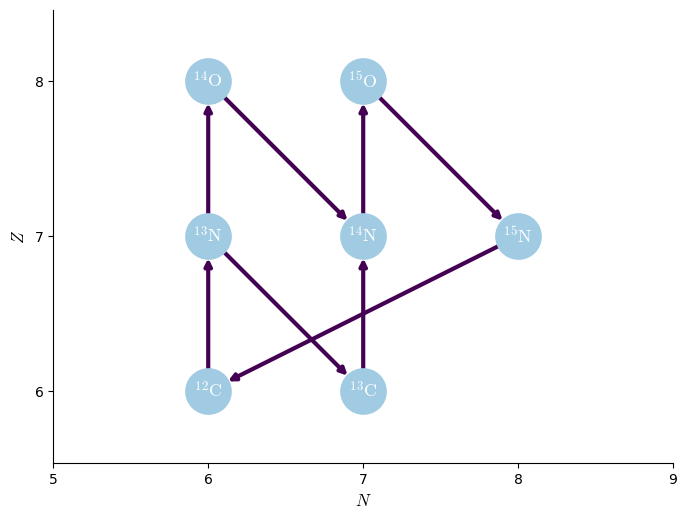

In [2]:
import pynucastro as pync

files = ["c12-pg-n13-ls09",
         "c13-pg-n14-nacr",
         "n13--c13-wc12",
         "n13-pg-o14-lg06",
         "n14-pg-o15-im05",
         "n15-pa-c12-nacr",
         "o14--n14-wc12",
         "o15--n15-wc12"]

pynet = pync.PythonNetwork(files)
pynet.plot()

#### We can also have the network show the rates' temperature and density dependences.

#### We generate the Python code to evaluate the RHS of the ODE problem.

In [3]:
pynet.write_network("cno_net_example.py")

In [4]:
%cat cno_net_example.py

import numpy as np
from pynucastro.rates import Tfactors
import numba

ip = 0
ihe4 = 1
ic12 = 2
ic13 = 3
in13 = 4
in14 = 5
in15 = 6
io14 = 7
io15 = 8
nnuc = 9

A = np.zeros((nnuc), dtype=np.int32)

A[ip] = 1
A[ihe4] = 4
A[ic12] = 12
A[ic13] = 13
A[in13] = 13
A[in14] = 14
A[in15] = 15
A[io14] = 14
A[io15] = 15

Z = np.zeros((nnuc), dtype=np.int32)

Z[ip] = 1
Z[ihe4] = 2
Z[ic12] = 6
Z[ic13] = 6
Z[in13] = 7
Z[in14] = 7
Z[in15] = 7
Z[io14] = 8
Z[io15] = 8

@numba.njit()
def ye(Y):
    return np.sum(Z * Y)/np.sum(A * Y)

@numba.njit()
def p_c12__n13(tf):
    # c12 + p --> n13
    rate = 0.0
    
    # ls09n
    rate += np.exp(  17.1482 + -13.692*tf.T913i + -0.230881*tf.T913
                  + 4.44362*tf.T9 + -3.15898*tf.T953 + -0.666667*tf.lnT9)
    # ls09r
    rate += np.exp(  17.5428 + -3.77849*tf.T9i + -5.10735*tf.T913i + -2.24111*tf.T913
                  + 0.148883*tf.T9 + -1.5*tf.lnT9)
    
    return rate

@numba.njit()
def p_c13__n14(tf):
    # c13 + p --> n14
    rate = 0.0
    
 

In [5]:
import cno_net_example

Because of the way I've coded the integrators below, I swap the `t` and `Y` inputs of the `rhs` function generated above.

In [6]:
def rhs(Y, t, rho, T):
    return cno_net_example.rhs_eq(t, Y, rho, T)

#### Set up the integrators and plot function

In [7]:
from scipy.linalg import lu_factor, lu_solve
import itertools

#forward difference jacobian, per the linked stackoverflow page
def J(f, x, dx=1e-8, **kwargs):
    #https://stackoverflow.com/questions/49553006/compute-the-jacobian-matrix-in-python
    n = len(x)
    func = f(x, **kwargs)
    jac = np.zeros((n, n), dtype=np.float64)
    for j in range(n):  # through columns to allow for vector addition
        Dxj = (abs(x[j])*dx if x[j] != 0 else dx)
        x_plus = [(xi if k != j else xi + Dxj) for k, xi in enumerate(x)]
        jac[:, j] = (f(x_plus, **kwargs) - func)/Dxj
    return jac

#use scipy to solve the ax=b matrix problem for x
def ax_b(a, b):
    lua = lu_factor(a)
    x = lu_solve(lua, b)
    return x

#the euler integration step
def euler_i(yn, rhs, h, **kwargs):
    fyn = rhs(yn, **kwargs) #evaluate f(y_n)
    jac = J(rhs, yn, **kwargs) #find jacobian
    I = np.eye(len(fyn)) #create identity with proper shape
    delta = ax_b(I/h-jac, fyn) #solve for delta
    return yn+delta #increment the abundances

#the kaps-rentrop step
def grk4t(yn, rhs, h, hmax=1e4, atol=1e-6, **kwargs):
    #coefficients:
    #https://rotordynamics.wordpress.com/2014/07/14/rosenbrock-grk4t-parameters/
    g = 0.231
    a21= 0.2000000000000000E01
    a31= 0.4524708207373116E01
    a32= 0.4163528788597648E01
    c21=-0.5071675338776316E01
    c31= 0.6020152728650786E01
    c32= 0.1597506846727117
    c41=-0.1856343618686113E01
    c42=-0.8505380858179826E01
    c43=-0.2084075136023187E01
    b1= 0.3957503746640777E01
    b2= 0.4624892388363313E01
    b3= 0.6174772638750108
    b4= 0.1282612945269037E01
    e1= 0.2302155402932996E01
    e2= 0.3073634485392623E01
    e3=-0.8732808018045032
    e4=-0.1282612945269037E01
    c2= 0.4620000000000000
    c3= 0.8802083333333334
    d1= 0.2310000000000000
    d2=-0.3962966775244303E-01
    d3= 0.5507789395789127
    d4=-0.5535098457052764E-01
    
    #create large error array for use in loop
    err = 1e10*np.ones_like(yn)
    nit = 0
    I = np.eye(len(yn)) #create identity
    jac = J(rhs, yn, **kwargs) #find jacobian
    while abs(err).sum() > atol: 
        nit += 1 #increment number of times the loop happens
        #jac = J(rhs, yn, **kwargs) #find jacobian
        #I = np.eye(len(yn))

        pref = I/(g*h)-jac #the prefactor of the matrix equation, with h-dependence

        
        #compose the increment as prescribed by the coefficients
        fyn1 = rhs(yn, **kwargs)
        Del1 = ax_b(pref, fyn1)

        fyn2 = rhs(yn+a21*Del1, **kwargs)
        Del2 = ax_b(pref, fyn2+c21*Del1/h)

        fyn3 = rhs(yn+a31*Del1+a32*Del2, **kwargs)
        Del3 = ax_b(pref, fyn3+(c31*Del1+c32*Del2)/h)

        Del4 = ax_b(pref, fyn3+(c41*Del1+c42*Del2+c43*Del3)/h)

        ynp1 = yn+b1*Del1+b2*Del2+b3*Del3+b4*Del4

        err = e1*Del1+e2*Del2+e3*Del3+e4*Del4

        #if the sum of the absolute values of this error estimate is too large,
        #continue loop with smaller h
        if abs(err).sum() <= atol:
            print('tolerance achieved in {} steps. h = {:6.4f}'.format(nit, h))
            break
        else:
            h = h/2
        
    if nit == 1:
        #grow h if convergence is easy and finished in 1 step
        h = h*3
        if h > hmax:
            #cap growth to hmax
            h = hmax
    
    #return next step abundances and the h value at convergence
    ret = np.append(ynp1, h)
    return ret
            
def bader_deuflhard(yn, rhs, H, Hmax=1e4, ms=[2,6, 10, 14, 22, 34, 50, 70],
                    atol=1e-8, **kwargs):
    assert type(ms) == list, "ms must be a list of length at least 2"
    assert len(ms) >= 2
    I = np.eye(len(yn))
    jac = J(rhs, yn, **kwargs)
    fyn = rhs(yn, **kwargs)
    
    #as the method creates many +1 steps, create a list to hold them
    ykp1s = []
    err = 1e10
    
    #loop over m values
    for m in ms:
        #initial step
        h = H/m
        Del0 = ax_b(I-h*jac, h*fyn)
        y1 = yn+Del0
        
        #rename variables for loop clarity
        yk = y1
        Delkm1 = Del0
        
        #loop iterations
        for k in range(1, m):
            fyk = rhs(yk, **kwargs)
            x = ax_b(I-h*jac, h*fyk-Delkm1)
            Delkm1 = Delkm1 + 2*x # "Delk"
            yk = yk+Delkm1 #"yk1"
        
        #final update steps
        fym = rhs(yk, **kwargs)
        Delm = ax_b(I-h*jac, h*fym-Delkm1)
        
        #append the stepped abundances to the list of them from different m values
        ykp1s.append(yk+Delm)
        
        
        if m > 5: #ie if m=6 step has been completed
            #at first m value where error can be estimated,
            #find sum of absolute differences between the
            #most recent and previous order increments
            err = abs(ykp1s[-1]-ykp1s[-2]).sum()
            
            
            if err < atol:
                print('tolerance achieved for m = {}'.format(m))
                break
            if m == ms[-1] and err > atol:
                print('error did not converge within tolerance')
        
    if m == 6:
        #grow H if convergence is quick
        H = H*3
        if H > Hmax:
            H = Hmax
    if m > 6:
        #if final m > 6, shrink H for easier convergence
        H = H/2
    ret = np.append(ykp1s[-1], H)
    return ret
            
    
def network_plot(ts, Ytot, nuc, title='', logscale=True, ymin=1e-7, bbox_to_anchor=(1.05,1)):
    lss = itertools.cycle(['-', '--', '-.', 'dotted'])
    f = plt.figure()
    ax = f.add_subplot(111)
    for i in range((Ytot.shape[1])):
        color = next(ax._get_lines.prop_cycler)['color']
        ax.plot(ts, Ytot[:, i], linestyle=next(lss), color=color, label=nuc[i])
    if logscale:
        ax.set_yscale('log')
        ax.set_xscale('log')
    ax.set_ylim(ymin, 1)
    ax.grid()
    ax.legend(bbox_to_anchor=bbox_to_anchor)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("$Y_i$")
    ax.set_title(title)


In [8]:
nuc = pynet.get_nuclei() #to set as plot labels

### Here the physical parameters are set up: temperature, density, and initial molar abundances.

In [9]:
ip = cno_net_example.ip
ihe4 = cno_net_example.ihe4
ic12 = cno_net_example.ic12
io15 = cno_net_example.io15

T = 0.5e8 #K
rho = 1500 #g/cm^3
Y0 = np.zeros_like(nuc, dtype=np.float64)
Y0[ip] = 0.7
Y0[ihe4] = 0.2
Y0[ic12] = 0.06
Y0[io15] = 0.04
Y0.sum()

1.0

### Here, the implicit Euler method drives the network progression, with a fixed step of $h=10^4$.

In [ ]:
tmax = 1e9
h=1e4
t = h
Yn = euler_i(Y0, rhs, h=h, t=h, T=T, rho=rho)
Ytot = np.vstack((Y0, Yn))
ts = [0, t]
while t < tmax:
    t+=h
    ts.append(t)
    Yn = euler_i(Yn, rhs, h=h, t=t, T=T, rho=rho)
    Ytot = np.vstack((Ytot, Yn))
    print(t)

/home/zingale/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'Y' of function 'rhs_eq'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "cno_net_example.py", line 163:
@numba.njit()
def rhs_eq(t, Y, rho, T):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


20000.0
30000.0
40000.0
50000.0
60000.0
70000.0
80000.0
90000.0
100000.0
110000.0
120000.0
130000.0
140000.0
150000.0
160000.0
170000.0
180000.0
190000.0
200000.0
210000.0
220000.0
230000.0
240000.0
250000.0
260000.0
270000.0
280000.0
290000.0
300000.0
310000.0
320000.0
330000.0
340000.0
350000.0
360000.0
370000.0
380000.0
390000.0
400000.0
410000.0
420000.0
430000.0
440000.0
450000.0
460000.0
470000.0
480000.0
490000.0
500000.0
510000.0
520000.0
530000.0
540000.0
550000.0
560000.0
570000.0
580000.0
590000.0
600000.0
610000.0
620000.0
630000.0
640000.0
650000.0
660000.0
670000.0
680000.0
690000.0
700000.0
710000.0
720000.0
730000.0
740000.0
750000.0
760000.0
770000.0
780000.0
790000.0
800000.0
810000.0
820000.0
830000.0
840000.0
850000.0
860000.0
870000.0
880000.0
890000.0
900000.0
910000.0
920000.0
930000.0
940000.0
950000.0
960000.0
970000.0
980000.0
990000.0
1000000.0
1010000.0
1020000.0
1030000.0
1040000.0
1050000.0
1060000.0
1070000.0
1080000.0
1090000.0
1100000.0
1110000.0
112000

### Here, the Kaps-Rentrop method is used for integration. The error estimate within the algorithm allows for timestep resizing to better capture quickly changing regions.

In [ ]:
tmax = 1e9
h=1
Yt = Y0
t = h
Ynh = grk4t(Y0, rhs, h=h, t=h, T=T, rho=rho)
Yn = Ynh[:-1]
h = Ynh[-1]
YKRtot = np.vstack((Y0, Yn))
tskr = [0, t]
while t < tmax:
    t+=h
    tskr.append(t)
    Ynh = grk4t(Yn, rhs, h=h, t=t, T=T, rho=rho)
    Yn = Ynh[:-1]
    h = Ynh[-1]
    YKRtot = np.vstack((YKRtot, Yn))
    print(t)

This function just generates a list of $m$ values used in the method. Per the [Numerical Recipes In Fortran
](https://isbnsearch.org/isbn/9780521430647), it's set up such that successive $m$ values differ by the smallest factor of such such that the ratio between them is $\leq 5/7$.

In [ ]:
def gen_ms(length):
    #per numerical recipes, each member differs from its predecessor
    # by the smallest multiple of 4 such that the ratio is <= 5/7
    ms = [2,6]
    for i in range(length):
        inc=1
        ratio = 1
        while ratio > (5/7):
            nnum = ms[-1]+4*inc
            ratio = ms[-1]/nnum
            inc += 1
        ms += [nnum]
    return ms
msl = gen_ms(50)
print(msl)

### Here, we use the Bader-Deuflhard method, again resizing the large timestep H as needed for easier convergence.

In [18]:
tmax = 1e9
H=1
Yt = Y0
t = H
YnH = bader_deuflhard(Y0, rhs, H=H, ms=msl, t=H, T=T, rho=rho)
Yn = YnH[:-1]
H = YnH[-1]
YBDtot = np.vstack((Y0, Yn))
tsbd = [0, t]
while t < tmax:
    t+=H
    tsbd.append(t)
    YnH = bader_deuflhard(Yn, rhs, H=H, ms=msl, t=t, T=T, rho=rho)
    Yn = YnH[:-1]
    H = YnH[-1]
    YBDtot = np.vstack((YBDtot, Yn))
    print(t)

tolerance achieved for m = 6
tolerance achieved for m = 6
4.0
tolerance achieved for m = 10
13.0
tolerance achieved for m = 10
17.5
tolerance achieved for m = 6
19.75
tolerance achieved for m = 10
26.5
tolerance achieved for m = 6
29.875
tolerance achieved for m = 10
40.0
tolerance achieved for m = 10
45.0625
tolerance achieved for m = 6
47.59375
tolerance achieved for m = 10
55.1875
tolerance achieved for m = 6
58.984375
tolerance achieved for m = 10
70.375
tolerance achieved for m = 10
76.0703125
tolerance achieved for m = 6
78.91796875
tolerance achieved for m = 10
87.4609375
tolerance achieved for m = 6
91.732421875
tolerance achieved for m = 10
104.546875
tolerance achieved for m = 10
110.9541015625
tolerance achieved for m = 6
114.15771484375
tolerance achieved for m = 10
123.7685546875
tolerance achieved for m = 10
128.573974609375
tolerance achieved for m = 6
130.9766845703125
tolerance achieved for m = 10
138.184814453125
tolerance achieved for m = 6
141.78887939453125
toleran

### Network plots

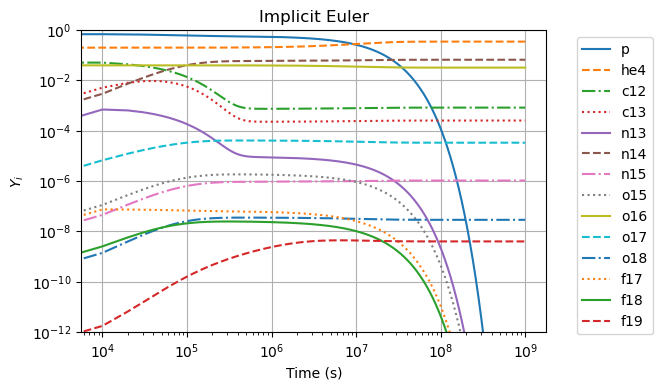

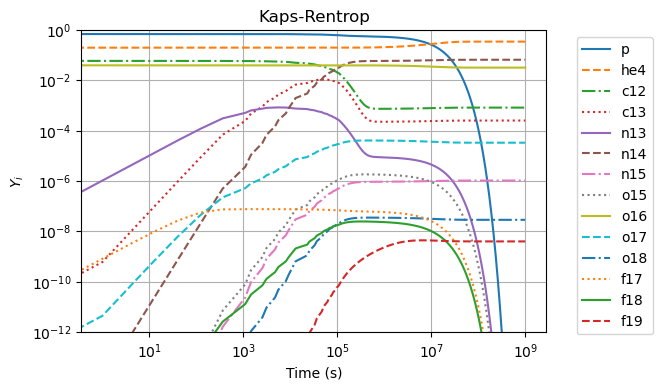

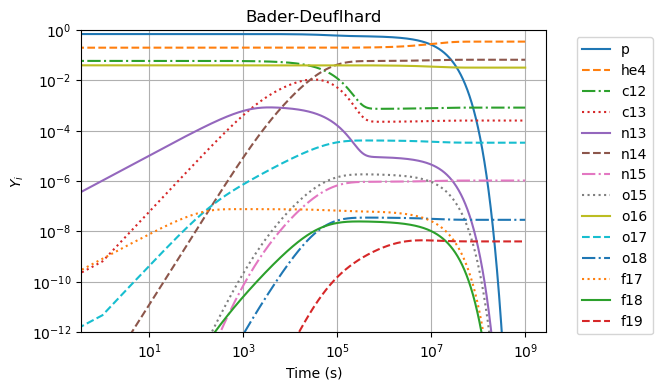

In [19]:
network_plot(ts, Ytot, nuc, title='Implicit Euler', ymin=1e-12)
network_plot(tskr, YKRtot, nuc, title='Kaps-Rentrop', ymin=1e-12)
network_plot(tsbd, YBDtot, nuc, title='Bader-Deuflhard', ymin=1e-12)

#### Because the $h$ or $H$ varies in the KR or BD methods, different numbers of steps occur. To examine differences between the methods, interopolate them into functions that will be evaluated on the same time grid.

In [20]:
from scipy.interpolate import interp1d
eufit = interp1d(ts, Ytot, axis=0)
krfit = interp1d(tskr, YKRtot, axis=0)
bdfit = interp1d(tsbd, YBDtot, axis=0)

In [21]:
eup = eufit(ts)
krp = krfit(ts)
bdp = bdfit(ts)

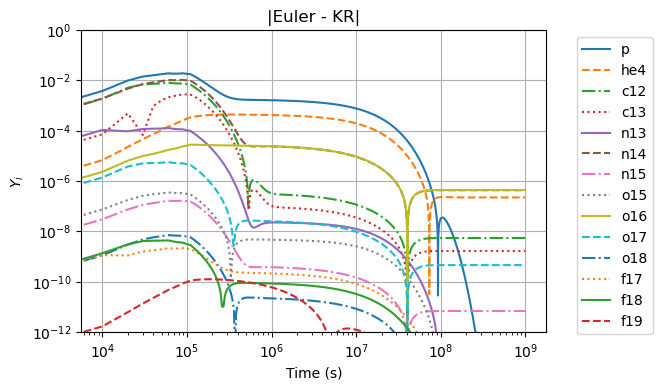

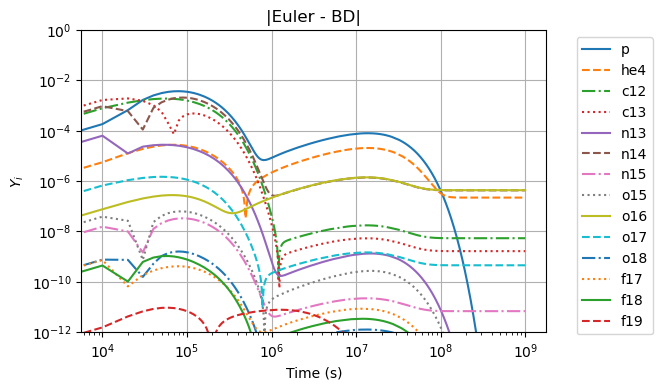

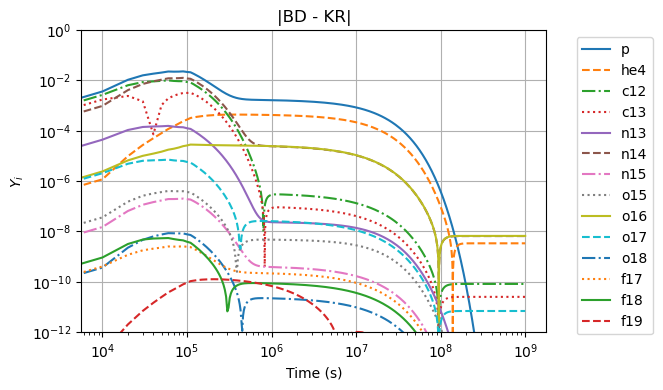

In [22]:
network_plot(ts, abs(eup-krp), nuc, title='|Euler - KR|', ymin=1e-12)
network_plot(ts, abs(eup-bdp), nuc, title='|Euler - BD|', ymin=1e-12)
network_plot(ts, abs(bdp-krp), nuc, title='|BD - KR|', ymin=1e-12)

#### Disclaimer:
The analyses and methods above are purely illustrative and might not be physically accurate. No attempt at integration optimization was made, and a proper error analysis wasn't done -- the graphs of method differences is again just illustrative.